In [4]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

Running on PyMC3 v3.0


## 1. Generating data
We can simulate some artificial data from this model using only NumPy’s random module, and then use PyMC3 to try to recover the corresponding parameters. We are intentionally generating the data to closely correspond the PyMC3 model structure.



In [5]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

Here is what the simulated data look like. We use the pylab module from the plotting library matplotlib.

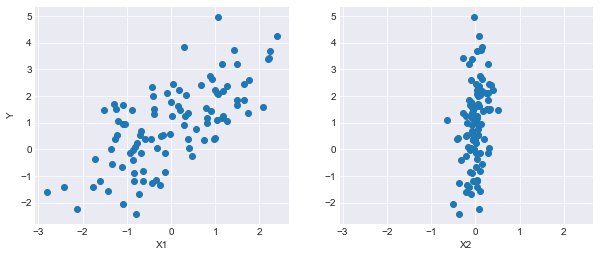

In [6]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

## 2. Model Specification
Specifying this model in PyMC3 is straightforward because the syntax is as close to the statistical notation. For the most part, each line of Python code corresponds to a line in the model notation above.

First, we import PyMC. We use the convention of importing it as pm.

In [7]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.0



Now we build our model, which we will present in full first, then explain each part line-by-line.

In [8]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)


The first line,
creates a new Model object which is a container for the model random variables.Following instantiation of the model, the subsequent specification of the model components is performed inside a with statement: 'with basic_model:'

This creates a context manager, with our basic_model as the context, that includes all statements until the indented block ends. This means all PyMC3 objects introduced in the indented code block below the with statement are added to the model behind the scenes. Absent this context manager idiom, we would be forced to manually associate each of the variables with basic_model right after we create them. If you try to create a new random variable without a with model: statement, it will raise an error since there is no obvious model for the variable to be added to.

The first three statements in the context manager:
create a stochastic random variables with a Normal prior distributions for the regression coefficients with a mean of 0 and standard deviation of 10 for the regression coefficients, and a half-normal distribution for the standard deviation of the observations, σ. These are stochastic because their values are partly determined by its parents in the dependency graph of random variables, which for priors are simple constants, and partly random (or stochastic).

We call the Normal constructor to create a random variable to use as a normal prior. The first argument is always the name of the random variable, which should almost always match the name of the Python variable being assigned to, since it sometimes used to retrieve the variable from the model for summarizing output. The remaining required arguments for a stochastic object are the parameters, in this case mu, the mean, and sd, the standard deviation, which we assign hyperparameter values for the model. In general, a distribution’s parameters are values that determine the location, shape or scale of the random variable, depending on the parameterization of the distribution. Most commonly used distributions, such as Beta, Exponential, Categorical, Gamma, Binomial and many others, are available in PyMC3.

The beta variable has an additional shape argument to denote it as a vector-valued parameter of size 2. The shape argument is available for all distributions and specifies the length or shape of the random variable, but is optional for scalar variables, since it defaults to a value of one. It can be an integer, to specify an array, or a tuple, to specify a multidimensional array (e.g. shape=(5,7) makes random variable that takes on 5 by 7 matrix values).

Having defined the priors, the next statement creates the expected value mu of the outcomes, specifying the linear relationship: 'mu = alpha + beta[0]*X1 + beta[1]*X2'

This creates a deterministic random variable, which implies that its value is completely determined by its parents’ values. That is, there is no uncertainty beyond that which is inherent in the parents’ values. Here, mu is just the sum of the intercept alpha and the two products of the coefficients in beta and the predictor variables, whatever their values may be.

PyMC3 random variables and data can be arbitrarily added, subtracted, divided, multiplied together and indexed-into to create new random variables. This allows for great model expressivity. Many common mathematical functions like sum, sin, exp and linear algebra functions like dot (for inner product) and inv (for inverse) are also provided.

The final line of the model, defines Y_obs, the sampling distribution of the outcomes in the dataset. 'Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)'.

This is a special case of a stochastic variable that we call an observed stochastic, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its observed argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a numpy.ndarray or pandas.DataFrame object.

Notice that, unlike for the priors of the model, the parameters for the normal distribution of Y_obs are not fixed values, but rather are the deterministic object mu and the stochastic sigma. This creates parent-child relationships between the likelihood and these two variables.





## 3. Model fitting

Having completely specified our model, the next step is to obtain posterior estimates for the unknown variables in the model. Ideally, we could calculate the posterior estimates analytically, but for most non-trivial models, this is not feasible. We will consider two approaches, whose appropriateness depends on the structure of the model and the goals of the analysis: finding the maximum a posteriori (MAP) point using optimization methods, and computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods.

### 3.1 Maximun a posteriori methods
The maximum a posteriori (MAP) estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution. PyMC3 provides this functionality with the find_MAP function.

Below we find the MAP for our original model. The MAP is returned as a parameter point, which is always represented by a Python dictionary of variable names to NumPy arrays of parameter values.



In [10]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

{'alpha': array(0.9065985497559482),
 'beta': array([ 0.94848602,  2.60705514]),
 'sigma_log': array(-0.03278147017403069)}

By default, find_MAP uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior but also allows selection of other optimization algorithms from the scipy.optimize module. For example, below we use Powell’s method to find the MAP.

In [11]:

from scipy import optimize

map_estimate = pm.find_MAP(model=basic_model, fmin=optimize.fmin_powell)

map_estimate

{'alpha': array(0.9090521898977764),
 'beta': array([ 0.95140146,  2.61437458]),
 'sigma_log': array(-0.030009775203258385)}

It is important to note that the MAP estimate is not always reasonable, especially if the mode is at an extreme. This can be a subtle issue; with high dimensional posteriors, one can have areas of extremely high density but low total probability because the volume is very small. This will often occur in hierarchical models with the variance parameter for the random effect. If the individual group means are all the same, the posterior will have near infinite density if the scale parameter for the group means is almost zero, even though the probability of such a small scale parameter will be small since the group means must be extremely close together.

Most techniques for finding the MAP estimate also only find a local optimum (which is often good enough), but can fail badly for multimodal posteriors if the different modes are meaningfully different.



### 3.2 Sampling methods

Though finding the MAP is a fast and easy way of obtaining estimates of the unknown model parameters, it is limited because there is no associated estimate of uncertainty produced with the MAP estimates. Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the posterior distribution.

To conduct MCMC sampling to generate posterior samples in PyMC3, we specify a step method object that corresponds to a particular MCMC algorithm, such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS). PyMC3’s step_methods submodule contains the following samplers: NUTS, Metropolis, Slice, HamiltonianMC, and BinaryMetropolis. These step methods can be assigned manually, or assigned automatically by PyMC3. Auto-assignment is based on the attributes of each variable in the model. In general:
* Binary variables will be assigned to BinaryMetropolis
* Discrete variables will be assigned to Metropolis
* Continuous variables will be assigned to NUTS

### 3.3 Gradient-based sampling methods

PyMC3 has the standard sampling algorithms like adaptive Metropolis-Hastings and adaptive slice sampling, but PyMC3’s most capable step method is the No-U-Turn Sampler. NUTS is especially useful on models that have many continuous parameters, a situation where other MCMC algorithms work very slowly. It takes advantage of information about where regions of higher probability are, based on the gradient of the log posterior-density. This helps it achieve dramatically faster convergence on large problems than traditional sampling methods achieve. PyMC3 relies on Theano to analytically compute model gradients via automatic differentiation of the posterior density. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo. For random variables that are undifferentiable (namely, discrete variables) NUTS cannot be used, but it may still be used on the differentiable variables in a model that contains undifferentiable variables.

NUTS requires a scaling matrix parameter, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, although NUTS uses it somewhat differently. The matrix gives the rough shape of the distribution so that NUTS does not make jumps that are too large in some directions and too small in other directions. It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling. This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions. Poor scaling parameters will slow down NUTS significantly, sometimes almost stopping it completely. A reasonable starting point for sampling can also be important for efficient sampling, but not as often.

Fortunately PyMC3 automatically initializes NUTS using another inference algorithm called ADVI (auto-diff variational inference). Moreover, PyMC3 will automatically assign an appropriate sampler if we don’t supply it via the step keyword argument (see below for an example of how to explicitly assign step methods).





In [12]:
from scipy import optimize

with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)

Assigned <class 'pymc3.step_methods.nuts.NUTS'> to alpha
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to beta
Assigned <class 'pymc3.step_methods.nuts.NUTS'> to sigma_log
 [-----------------100%-----------------] 500 of 500 complete in 0.5 sec

The sample function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns a Trace object containing the samples collected, in the order they were collected. The trace object can be queried in a similar way to a dict containing a map from variable names to numpy.arrays. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. We can see the last 5 values for the alpha variable as follows:

In [14]:
trace['alpha'][-5:]

array([ 0.8676918 ,  0.84982001,  0.93112557,  0.65932339,  1.15062412])

If we wanted to use the slice sampling algorithm to sigma instead of NUTS (which was assigned automatically), we could have specified this as the step argument for sample.

In [15]:
with basic_model:

    # obtain starting values via MAP
    start = pm.find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, start=start)

 [-----------------100%-----------------] 5000 of 5000 complete in 27.6 sec

## 4. Posterior analysis

PyMC3 provides plotting and summarization functions for inspecting the sampling output. A simple posterior plot can be created using traceplot.

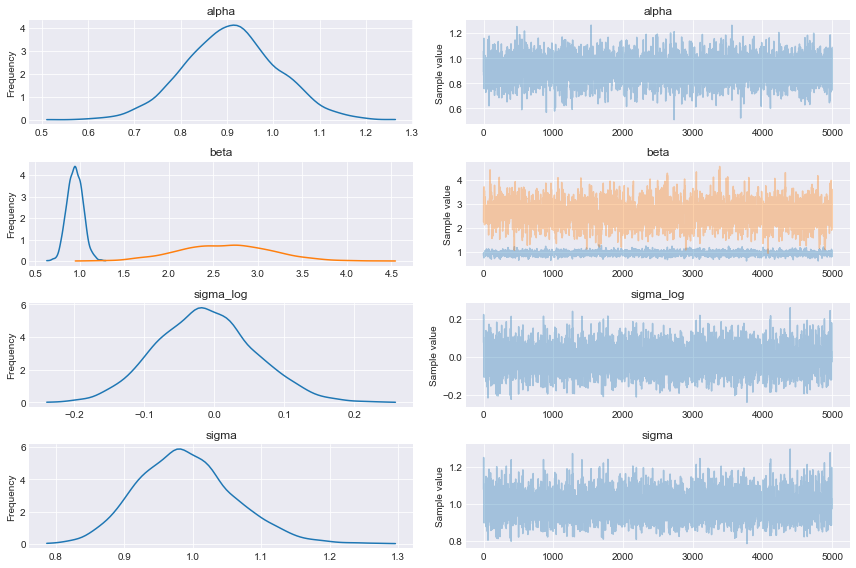

In [16]:
_ = pm.traceplot(trace)

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

In addition, the summary function provides a text-based output of common posterior statistics:

In [17]:
pm.summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.909            0.100            0.001            [0.707, 1.097]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.713          0.843          0.909          0.974          1.107


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.948            0.088            0.002            [0.779, 1.116]
  2.631            0.511            0.014            [1.617, 3.583]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.784          0.888          0.948          1.009          1.129
  1.647          2.273          2.635   